In [1]:
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

from sde.experiment_reports_owen import (
    PlotResults,
    sample_data,
    mean_min_loss,
)

%load_ext autoreload
%autoreload 2

In [77]:
# notebook parameters
n_dimensions = 1
step_size = 2e-1
n_pts = 10000
n_subsample = 1

random_seed = 1
rng = np.random.default_rng(random_seed)

In [78]:
# generate training data
def true_drift(x):
    result = - (np.sin(2 * np.pi * x) + 0.5 * x**3 - 2 * np.exp(-5 * x**2))
    return result.reshape(-1, 1)

def true_diffusion(x):
    result = 0.1 * (0.5 + 0.5 * np.abs(x) + 0.3 * np.sin(3 * x) + 0.1 * x**4)
    return result.reshape(-1, 1)


def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)


xlim = np.array([[-1, 1]])

x_data, y_data = sample_data(true_drift_diffusion,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=xlim[:,0], high=xlim[:,1], n_pts=n_pts,
                             rng=rng, n_subsample=n_subsample)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

print('data shape', x_data.shape)

data shape (10000, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

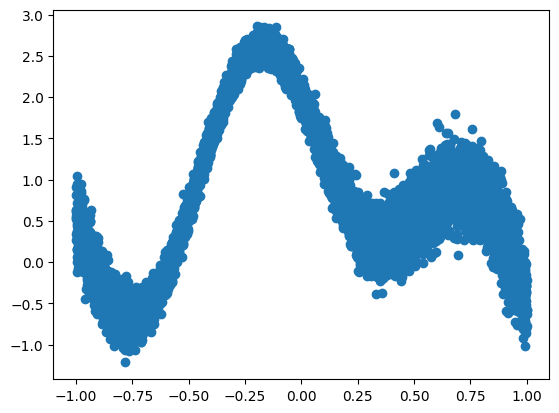

In [79]:
import matplotlib.pyplot as plt
plt.scatter(x_data, (y_data-x_data)/step_size)
x_grid = np.linspace(-1, 1, 100)
plt.plot(x_grid, true_drift(x_grid))
plt.show

In [80]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**9, 
                                M_min=50,
                                M_max=300,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')


In [81]:
# calculate theoretical mean min loss (integral over loss function)
mean_min_loss(true_diffusion, n_pts, validation_split, step_size, xlim)


Theoretical mean min loss: -2.018189849417383
Loss standard deviation: 0.007453559924999299
Validation loss standard deviation: 0.022360679774997897


drift epoch: 101


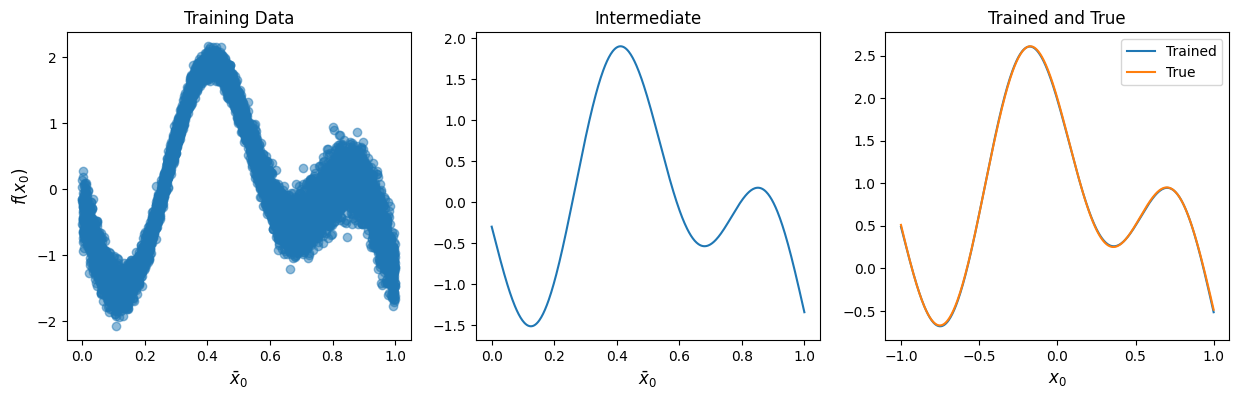

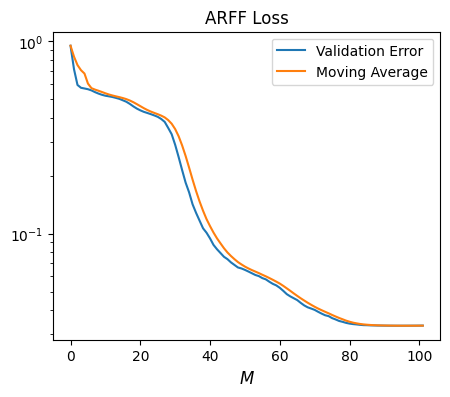

diff epoch: 50


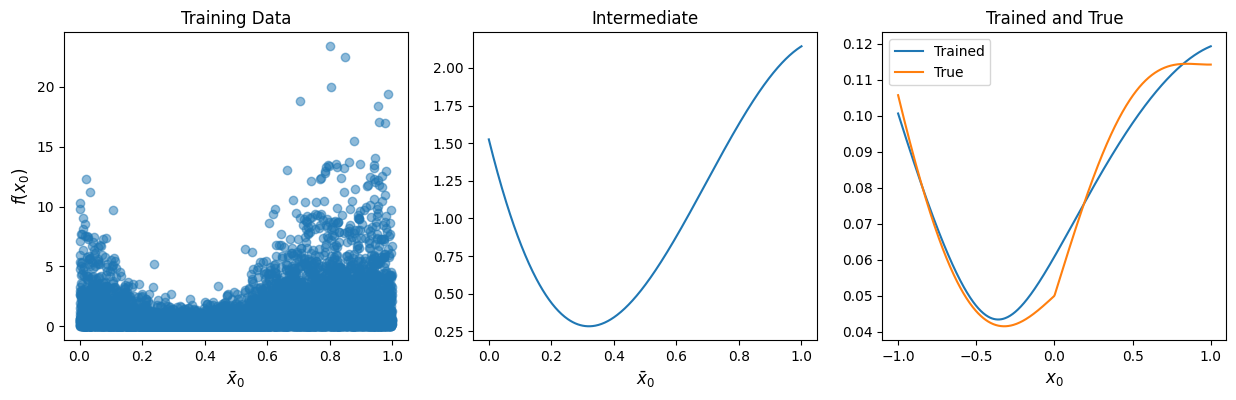

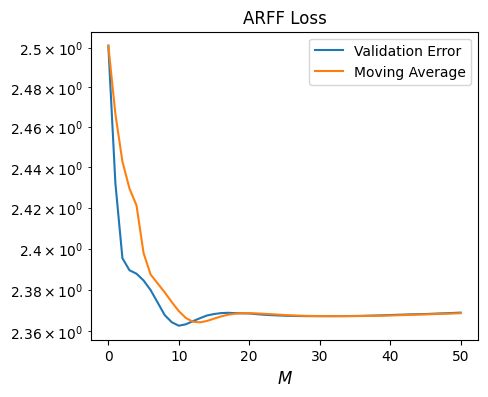

Observed loss: -2.015078116014491
Observed validation loss: -2.032232061234685
True function validation loss: -1.8376867391468232
Training time: 74.20757293701172


In [82]:
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, resampling=True)
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]

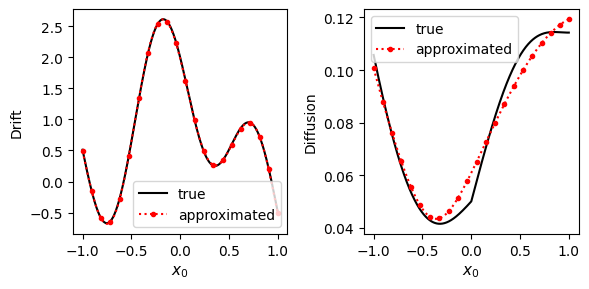

In [83]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_subsample)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=False)

PR.plot_results_functions(SAT.drift_diffusion, true_drift_diffusion, x_data, save=True)

# time = 100*step_size
# PR.plot_histogram(true_drift_diffusion, step_size/n_subsample, time, rng, xlim, name='True', save=False)
# PR.plot_histogram(SAT.drift_diffusion, step_size, time, rng, xlim, name='ARFF', save=False)
